# Intro

This is a WIP notebook with an approach for the House Prices prediction competition. Any feedback would be greatly appreciated!

In [1]:
!pip install catboost
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# EDA

Let's import the train and test data and see what we're dealing with

In [2]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Looking at the initial dataframe together with the `data_description.txt` file, we can see there's mostly categorical data, with some scalar values (including our target **y** `SalePrice`).

In [3]:
import numpy as np

categorical_features = train_data.select_dtypes(include=["object"]).columns

skip_cols = ["Id", "SalePrice"]

scalar_features = train_data.drop(columns=np.concatenate([categorical_features, skip_cols])).columns.tolist()

Now that we've identified what kind of data we got in these columns, let's try to graph this.

To do this simply, let's try first to reduce the dimensions needed to explain the variance of the scalar variables:

In [4]:
scalar_data = train_data[scalar_features].copy()
scalar_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [5]:
missing_value_cols = []
for col in scalar_features:
    if scalar_data[col].isna().any():
        print("Column", col, "contains", scalar_data[col].isna().sum(), "nulls")
        missing_value_cols.append(col)
    elif test_data[col].isna().any():
        print("Column", col, "contains", test_data[col].isna().sum(), "nulls for the test data")
        missing_value_cols.append(col)

Column LotFrontage contains 259 nulls
Column MasVnrArea contains 8 nulls
Column BsmtFinSF1 contains 1 nulls for the test data
Column BsmtFinSF2 contains 1 nulls for the test data
Column BsmtUnfSF contains 1 nulls for the test data
Column TotalBsmtSF contains 1 nulls for the test data
Column BsmtFullBath contains 2 nulls for the test data
Column BsmtHalfBath contains 2 nulls for the test data
Column GarageYrBlt contains 81 nulls
Column GarageCars contains 1 nulls for the test data
Column GarageArea contains 1 nulls for the test data


We'll have to fill some values for these features

In [6]:
scalar_data[missing_value_cols].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
count,1201.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000
mean,70.049958,103.685262,443.639726,46.549315,567.240411,1057.429452,0.425342,0.057534,1978.506164,1.767123,472.980137
std,24.284752,181.066207,456.098091,161.319273,441.866955,438.705324,0.518911,0.238753,24.689725,0.747315,213.804841
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000
25%,59.000000,0.000000,0.000000,0.000000,223.000000,795.750000,0.000000,0.000000,1961.000000,1.000000,334.500000
50%,69.000000,0.000000,383.500000,0.000000,477.500000,991.500000,0.000000,0.000000,1980.000000,2.000000,480.000000
75%,80.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,313.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,3.000000,2.000000,2010.000000,4.000000,1418.000000


We'll assume 0 for the missing values since they refer to missing features in a house

In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
imputed_data = pd.DataFrame(imputer.fit_transform(scalar_data[missing_value_cols]))
imputed_data.columns = scalar_data[missing_value_cols].columns
scalar_data[missing_value_cols] = imputed_data

scalar_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [8]:
scalar_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


# PCA decomposition

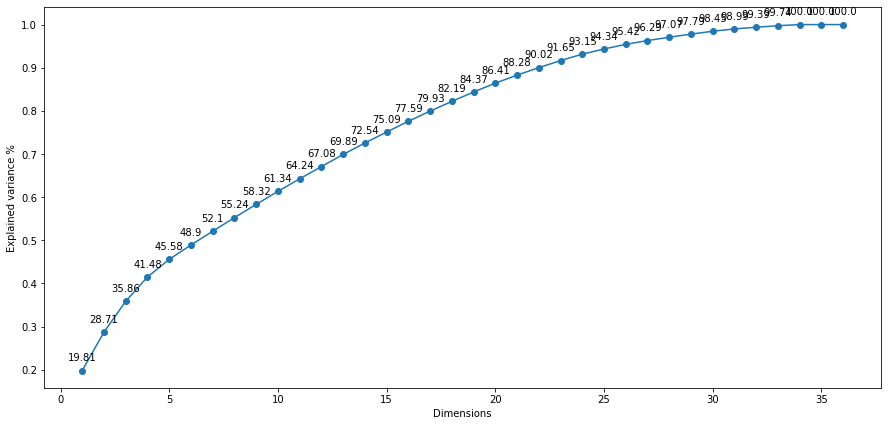

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

pca_pipe = make_pipeline(StandardScaler(), PCA(random_state=1))
pca_pipe.fit(scalar_data)

pca_model = pca_pipe.named_steps["pca"]

cumsum = np.cumsum(pca_model.explained_variance_ratio_)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
ax.plot(np.arange(len(scalar_data.columns)) + 1,cumsum, marker = 'o')
plt.xlabel("Dimensions")
plt.ylabel("Explained variance %")
for x, y in zip(np.arange(len(scalar_data.columns)) + 1, cumsum):
    label = round(y * 100, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')

Based on the previous plot, we can determine that 27 dimensions explain more than 98% of the variance, so we'll use that as our standard:

In [10]:
y = train_data["SalePrice"]
imputer = SimpleImputer()
imp_train_data = pd.DataFrame(imputer.fit_transform(train_data[missing_value_cols]))
imp_train_data.columns = train_data[missing_value_cols].columns
train_data[missing_value_cols] = imp_train_data

imp_test_data = pd.DataFrame(imputer.transform(test_data[missing_value_cols]))
imp_test_data.columns = test_data[missing_value_cols].columns
test_data[missing_value_cols] = imp_test_data

data_pipe = make_pipeline(StandardScaler(), PCA(n_components=27))
data_pipe.fit(train_data[scalar_features])

train_data_tfd = pd.DataFrame(data_pipe.transform(train_data[scalar_features]))
test_data_tfd = pd.DataFrame(data_pipe.transform(test_data[scalar_features]))

train_data_tfd.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.466841,0.374028,-1.699483,-1.939703,0.528759,-1.217341,-0.816449,-0.170194,-0.584484,0.004577,...,0.166001,-0.650400,0.690108,0.143637,0.398358,-0.033808,-0.379038,-0.242802,-0.277901,0.640872
1,-0.034630,-1.057457,1.257058,-0.038177,-1.735918,0.326446,3.481818,-0.633326,-0.045103,0.252992,...,0.173197,-0.013866,0.405640,-1.367631,-0.594219,-0.296820,0.667647,0.182126,-0.309783,-0.854333
2,1.653108,0.251644,-1.476703,-1.377065,-0.129468,0.323339,-0.475746,-0.151143,-0.635920,-0.030755,...,-0.540665,0.534283,0.831367,0.590227,-0.389050,0.031069,-0.371002,-0.372117,0.296358,0.465786
3,-0.368965,1.035379,0.773045,-0.183731,0.482313,-0.377488,-1.668948,0.891008,-1.613622,-1.462279,...,0.935138,0.010131,0.689279,-1.582266,0.596996,0.051327,-0.070401,-0.278254,1.259199,0.591425
4,4.411267,1.117394,-0.516154,-1.395286,-0.106587,0.689684,0.155217,-0.521148,-1.104035,0.188735,...,-0.990665,0.401280,-0.452972,0.366146,0.289512,-0.205093,-0.454840,-0.021584,0.791138,0.405777


# Categorical encoding

Now, let's encode the categories into integer data

In [11]:
from sklearn.preprocessing import OrdinalEncoder

train_data_enc = train_data[categorical_features].fillna("No")
train_data_enc["MSZoning"] = train_data_enc["MSZoning"].replace(['C (all)'], 'C')

test_data_enc = test_data[categorical_features].fillna("No")
test_data_enc["MSZoning"] = test_data_enc["MSZoning"].replace(['C (all)'], 'C')

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

encoder.fit(train_data_enc[categorical_features])

train_data_enc[categorical_features] = encoder.transform(train_data_enc[categorical_features])
test_data_enc[categorical_features] = encoder.transform(test_data_enc[categorical_features])

train_data_enc.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
1,3.0,1.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
2,3.0,1.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
3,3.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
4,3.0,1.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0


# Joining all features

In [12]:
train_data_joined = train_data_tfd.join(train_data_enc)
test_data_joined = test_data_tfd.join(test_data_enc)

# Fitting

We'll proceed to build a couple models with these values, and determine best through mean squared error.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor

X = train_data_joined

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

regression_model = LinearRegression()
regression_model = regression_model.fit(X_train,y_train)

print("SME for LinearRegression:", mean_squared_error(y_valid, regression_model.predict(X_valid)))

regression_model = LinearRegression()

poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X_train)

regression_model = regression_model.fit(X_poly,y_train)

print("SME for LinearRegression with poly features (3rd degree):", mean_squared_error(y_valid, regression_model.predict(poly_features.transform(X_valid))))

svr_model = LinearSVR(C=50, epsilon=0.5)
svr_model.fit(X_train, y_train)

print("SME for SVM regressor:", mean_squared_error(y_valid, svr_model.predict(X_valid)))

cb_model = CatBoostRegressor(depth= 10, iterations=35, learning_rate=0.5, silent=True)
cb_model.fit(X_train, y_train)
print("SME for CatBoost regressor:", mean_squared_error(y_valid, cb_model.predict(X_valid)))

SME for LinearRegression: 850063012.3602211


# Predict

In [ ]:
cb_model = CatBoostRegressor(depth= 10, iterations=35, learning_rate=0.5, silent=True)
cb_model.fit(X, y)

y_pred = cb_model.predict(test_data_joined)
submission = pd.DataFrame(test_data[["Id"]])
submission["SalePrice"] = y_pred

submission.to_csv("submission.csv", index=False)